In [1]:
%load_ext autoreload

%autoreload 2

import os

os.environ["MKL_NUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"

import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import uMAIA
from uMAIA.utils.tools import extract_image_coordinates
import pandas as pd
import tqdm


/home/halima/anaconda3/envs/uMAIA_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def visualize_ranges_test(smz, PF, clip=100, img_shape=None):
    """
    Extract images from the smzObj according to extracted ranges defined in df and save into AnnData object (.h5ad) format
    
    Args
    ----
    smz: smzObj
    df: pd.DataFrame
        dataframe containing extracted ranges from smz. Relevant columns are ['min', 'max', 'mz_estimated']
    filepath: str
        path to save .h5ad file
    mz_list: list[float], optional
        list containing m/z values of molecules desired for imaging. Approximations are made if the mz value is not present in df.
        no value provided will save all molecules present in df by default
    normalization: str or float, default='tic'
        indication of normalization form. when 'tic' is provided, images are normalized by the 
    clip: int, optional
        percentile to clip images
        default, no clipping
    """
    
    tic_pixels = np.array(smz.S.sum(axis=1)).flatten()
    
    if img_shape is None:
        img_shape = smz.img_shape

    image_list = {}
    for i, r in tqdm.tqdm(enumerate(PF.ranges), total=len(PF.ranges)):

        mz_select_ = (smz.mz_vals > r[0]) & (smz.mz_vals < r[1])
        S_select = smz.S[:,mz_select_].toarray()
        mz = smz.mz_vals[mz_select_]

        img = np.sum(S_select, axis=1)
        # tic normalization
        img = img / tic_pixels

        # clip to nth percentile
        percentile = np.percentile(img, clip)
        img = np.clip(img, 0, percentile)

        if img.shape[0] < np.multiply(*img_shape):
            img = extract_image_coordinates(smz.reader.coordinates, img_shape, img)
        else:
            img = img[:np.multiply(*img_shape)].reshape(img_shape)
            
        image_list[f'{np.mean(r):.5f}'] = img
    return image_list



# Parameter Selection

1. mz_resolution: Parameter should be about 1/6th of the typical maxmimum mass error within a peak (in Daltons)
2. threshold_count: Frequency number at which the adaptive peak calling will stop increasing bin sizes. Please make sure data is baseline normalised (typical for TOF datasets)
3. approximate_interval: Size of the portion of the spectrum that is provided to the peak caller at a given instance. Can be decreased if memory capacity is small.
4. smoothing: sigma of 1D Gaussian filter smoothing on the frequency domain. For noisy mass errors, increase sigma, otherwise sigma can stay a small value (default=1). Use the plot_freqmz function below to determine the best parameter for your dataset.

# dataset 1: tims-tof

In [3]:
# set parameters
mz_resolution = 6e-4 #1e-4
threshold_count = 8.
path_data = '/data/lipidatlas/data/external_data/janinaData2/'
name = '20221116_ratcerebellum_lipids_m1_timsoff'

smz = uMAIA.ut.SmzMLobj(f'{os.path.join(path_data,name)}.ibd',
                           f'{os.path.join(path_data,name)}.imzML',
                           mz_resolution=mz_resolution)#, selected_pixels=(0,4000))

smz.load(load_unique_mz=True)
smz.S


/home/halima/anaconda3/envs/uMAIA_env/lib/python3.11/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(
Loading Spectra at resolution 0.0006: 100%|██████████| 41428/41428 [00:01<00:00, 32070.38it/s]
Loading the m/z values at resolution 0.0006: 41428it [00:00, 69185.40it/s]
41428it [00:06, 6052.07it/s]


<41428x3049 sparse matrix of type '<class 'numpy.float64'>'
	with 5902186 stored elements in Compressed Sparse Column format>

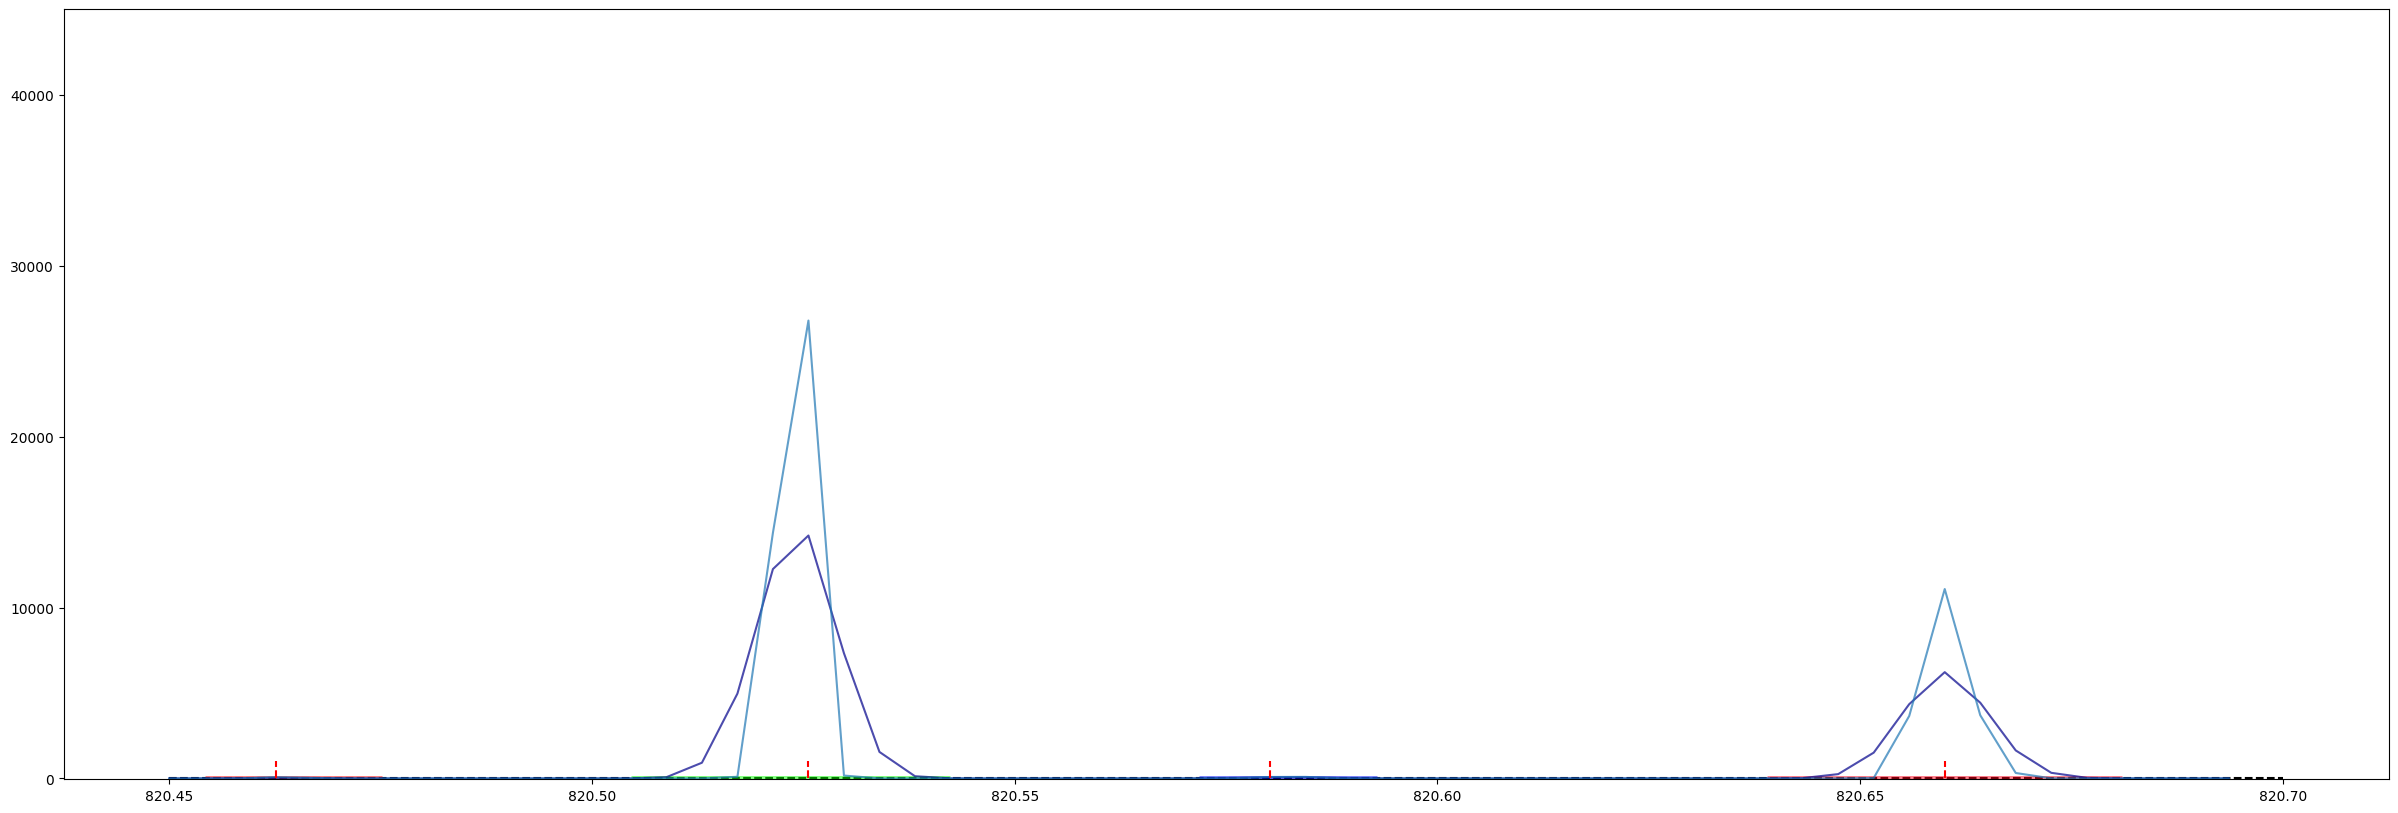

In [4]:
# smoothing on the frequency domain. for noisy mass errors, increase sigma, otherwise sigma can stay 
# a small value. use the plot_freqmz function to determine the best parameter for your dataset.
smoothing = 1.

# approximate interval refers to the size of the portion of the spectrum that is provided to the peak caller at a given instance
# if your machine throws an error, or the kernel stops, try decreasing this value
approximate_interval =.5


mzrange_test = np.array([820.45, 820.7]) # select a small window in the m/z spectrum that captures a reference compound
PF = uMAIA.vis.plot_freqmz(smz, 
                          mzrange_test, 
                          bins=True,
                          smoothing=smoothing, 
                          ylim=45000, 
                          threshold_count=threshold_count, 
                          approximate_interval=approximate_interval,
                          parallelize=True, 
                          mz_resolution=mz_resolution)

for m in PF.data_mz[PF.seeds]:
    plt.vlines(m, 0,1000,linestyle='--', color='r')

100%|██████████| 4/4 [00:00<00:00, 36.11it/s]


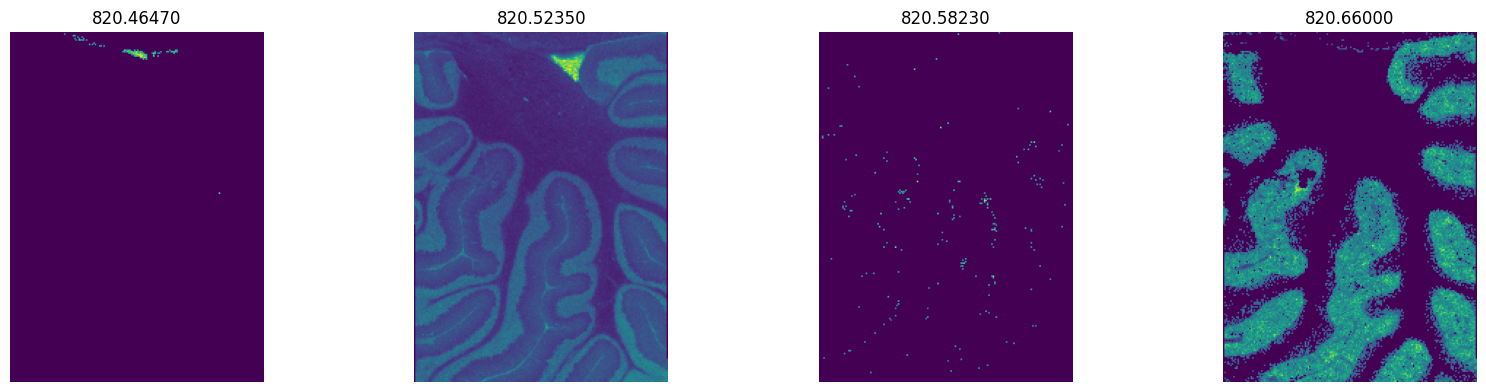

In [5]:
images = visualize_ranges_test(smz, PF)
fig = plt.figure(None, (20,10))
gs = plt.GridSpec(2,4)
for i, (mz, img) in enumerate(images.items()):
    plt.subplot(gs[i])
    plt.imshow(img)
    plt.title(mz)
    plt.axis('off')
    
    

## peakcalling the full spectrum
the following command extracts all images from the acquisition

In [ ]:
uMAIA.pf.run(directory_path=os.path.join(path_save, name), # input directory for saving peak-called objects
            smz=smz, 
            spectrum_range=(400,1200), # indicate the mz spectrum you wish to image
            threshold_count=threshold_count, 
            approximate_interval=approximate_interval,
            smoothing=smoothing,
            parallelize=True,
            saveimages=True  # whether images should be saved automatically
            )

# dataset 2: TOF

In [6]:
mz_resolution = 10e-4
threshold_count = 8.

path_data = '/data/lipidatlas/data/external_data/TOF/mouse_brain_pen_dhb_20um-root-mean-square/'
path_save = '/data/lipidatlas/data/external_data/TOF'
name = 'mouse_brain_pen_dhb_20um-root-mean-square'


smz = uMAIA.ut.SmzMLobj(f'{os.path.join(path_data,name)}.ibd',
                           f'{os.path.join(path_data,name)}.imzML',
                           mz_resolution=mz_resolution)

smz.load(load_unique_mz=True)
smz.S

/home/halima/anaconda3/envs/uMAIA_env/lib/python3.11/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(
Loading Spectra at resolution 0.001: 100%|██████████| 131864/131864 [00:05<00:00, 25750.64it/s]
Loading the m/z values at resolution 0.001: 131864it [00:15, 8399.77it/s]
131864it [08:11, 268.15it/s]


<131864x141896 sparse matrix of type '<class 'numpy.float64'>'
	with 128647539 stored elements in Compressed Sparse Column format>

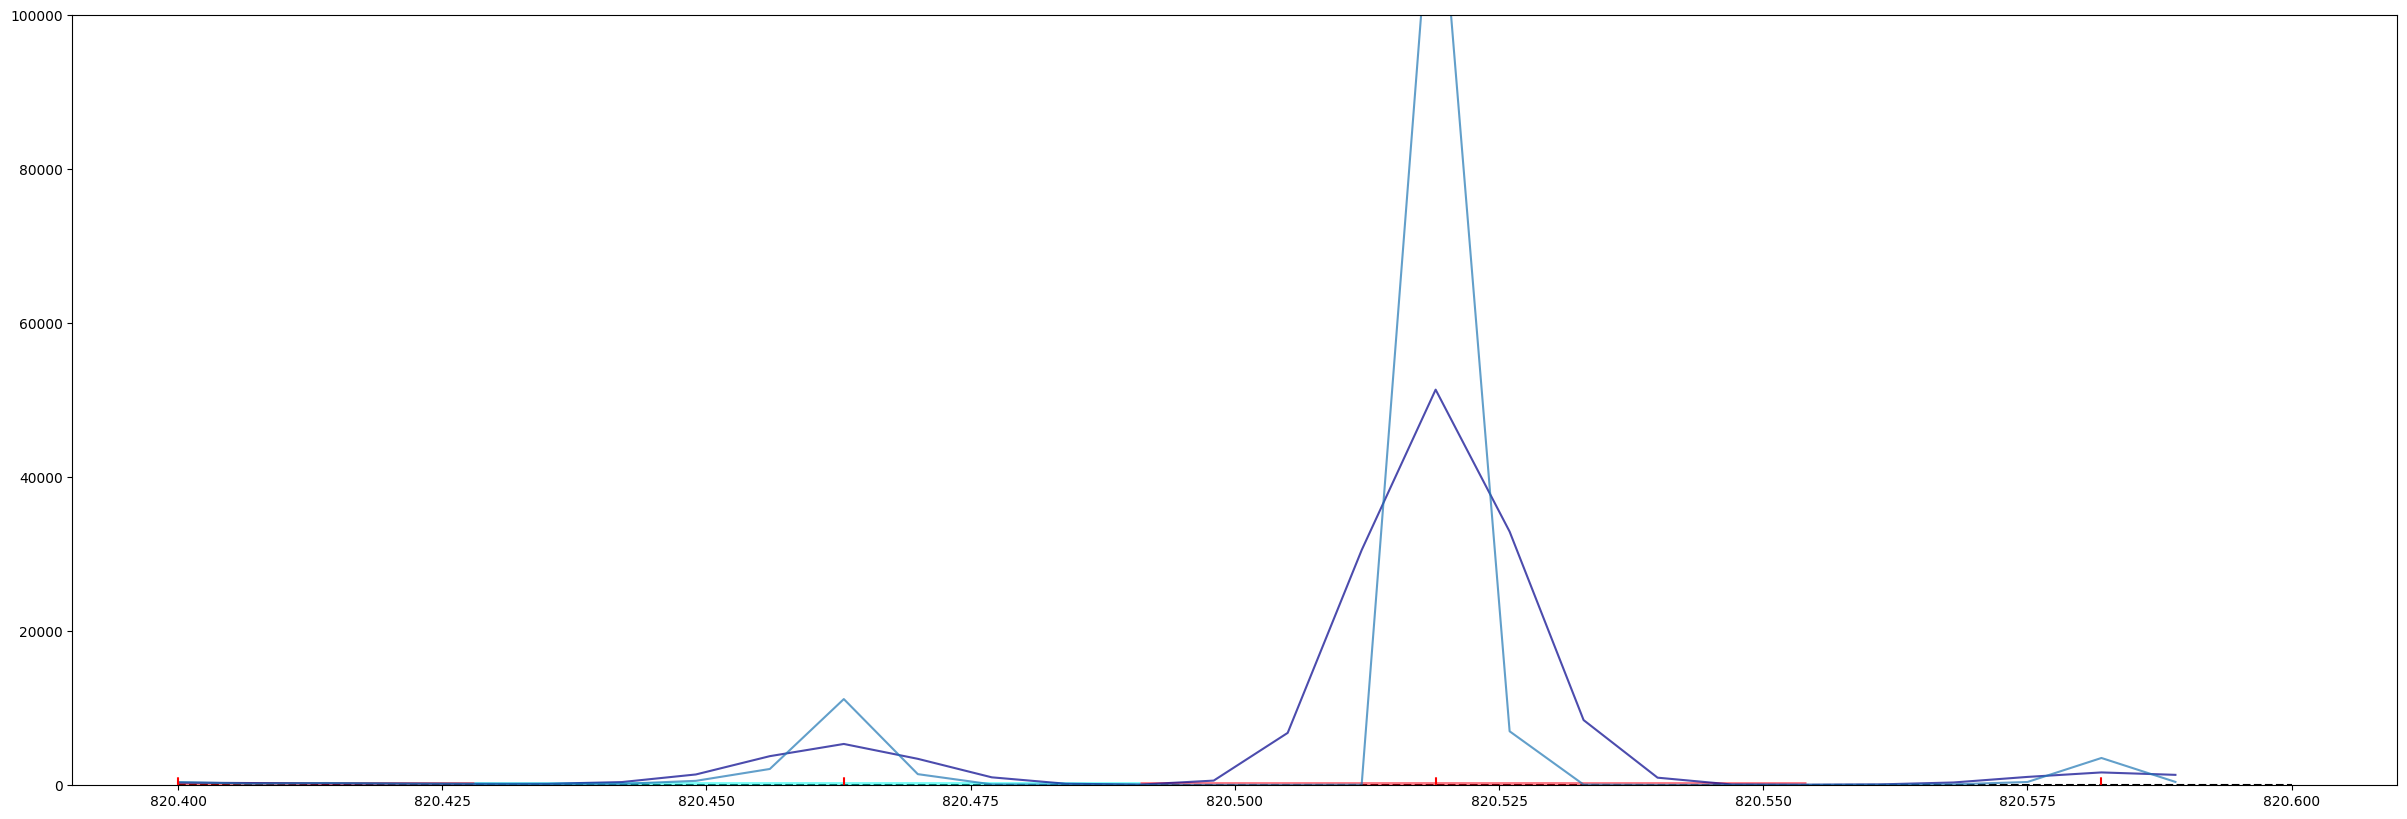

In [25]:
# approximate interval refers to the size of the portion of the spectrum that is provided to the peak caller at a given instance
# if your machine throws an error, or the kernel stops, try decreasing this value
approximate_interval =.5

# smoothing on the frequency domain. for noisy mass errors, increase sigma, otherwise sigma can stay 
# a small value. use the plot_freqmz function to determine the best parameter for your dataset.
smoothing = 1.

mzrange_test = np.array([820.4, 820.6])

PF = uMAIA.vis.plot_freqmz(smz, 
                          mzrange_test, 
                          bins=True,
                          smoothing=smoothing, 
                          ylim=10e4, 
                          threshold_count=threshold_count, 
                          approximate_interval=approximate_interval,
                          parallelize=True, 
                          mz_resolution=mz_resolution)

for m in PF.data_mz[PF.seeds]:
    plt.vlines(m, 0,1000,linestyle='--', color='r')

100%|██████████| 3/3 [00:00<00:00, 10.70it/s]


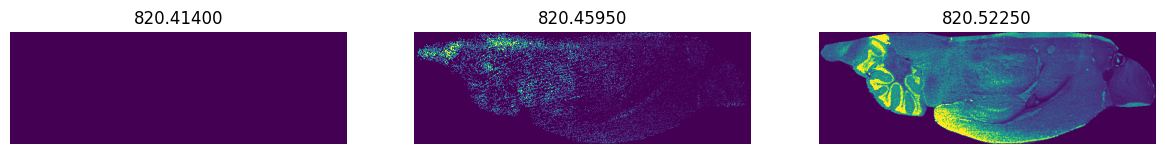

In [30]:
images = visualize_ranges_test(smz, PF)
fig = plt.figure(None, (20,10))
gs = plt.GridSpec(1,4)
for i, (mz, img) in enumerate(images.items()):
    plt.subplot(gs[i])
    plt.imshow(img, vmax=np.percentile(img, 98))
    plt.title(mz)
    plt.axis('off')
    
    

# Dataset 3: Orbitrap
data downloadable from METASPACE https://metaspace2020.eu/datasets?prj=fd035620-e6de-11ee-86c1-7fce1db28462&page=4

In [33]:
# resolution should be about 1/5th of the maxmimum mass error across peaks (in Daltons)
mz_resolution = 10e-5
threshold_count = 8.

path_data = '/data/lipidatlas/data/zebrafish/Atlas_72h_fish2/'
path_save = '/data/lipidatlas/data/zebrafish/Atlas_72h_fish2/'
name = '20220701_Zebrafish_atlas_72hpf_fish2_section_16_420x124_Att35_7um'

smz = uMAIA.ut.SmzMLobj(f'{os.path.join(path_data,name,name)}.IBD',
                           f'{os.path.join(path_data,name,name)}.imzml',
                           mz_resolution=10e-5)

smz.load(load_unique_mz=True)
smz.S

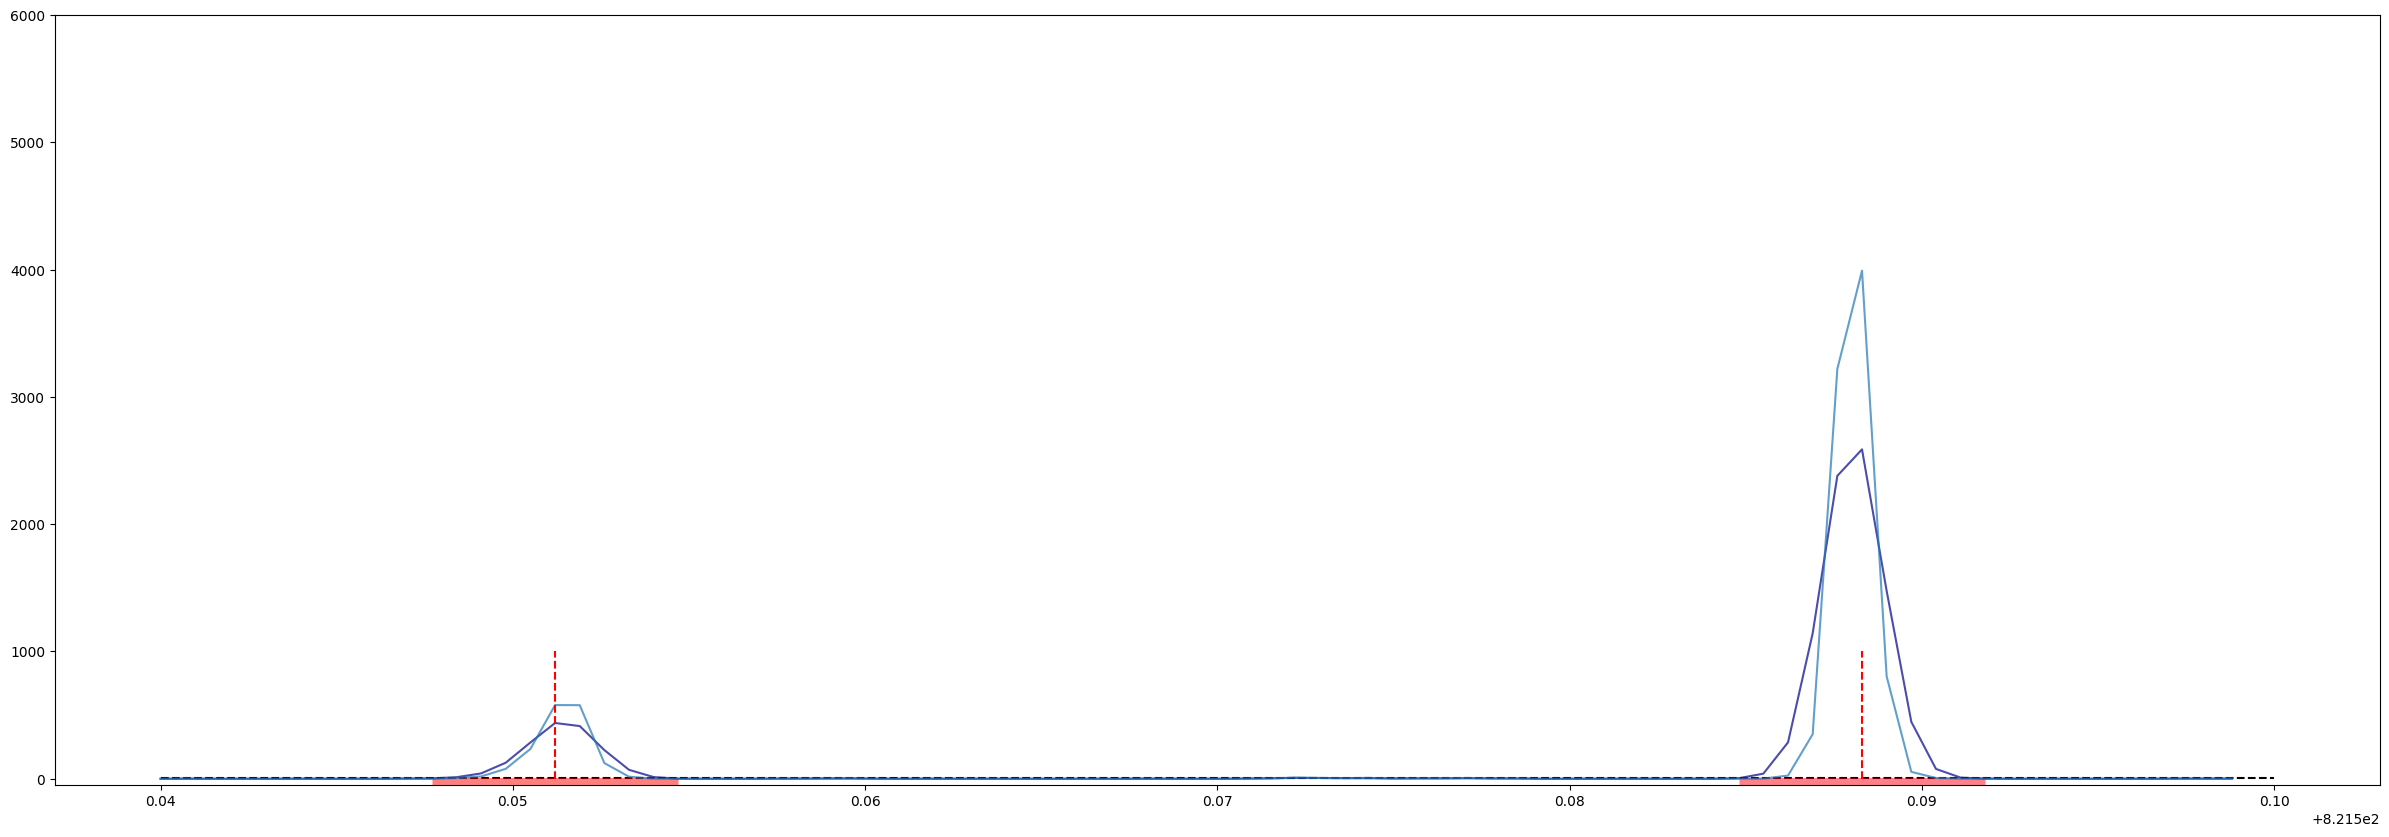

In [35]:


# approximate interval refers to the size of the portion of the spectrum that is provided to the peak caller at a given instance
# if your machine throws an error, or the kernel stops, try decreasing this value
approximate_interval =.5

# smoothing on the frequency domain. for extremely noisy mass errors, increase sigma, otherwise sigma can stay 
# a small value. use the plot_freqmz function to determine the best parameter for your dataset.
smoothing = 1.

mzrange_test = np.array([821.54, 821.6])

PF = uMAIA.vis.plot_freqmz(smz, 
                          mzrange_test, 
                          bins=True,
                          smoothing=smoothing, 
                          ylim=6000, 
                          threshold_count=threshold_count, 
                          approximate_interval=approximate_interval,
                          parallelize=True, 
                          mz_resolution=mz_resolution)

for m in PF.data_mz[PF.seeds]:
    plt.vlines(m, 0,1000,linestyle='--', color='r')

100%|██████████| 2/2 [00:00<00:00, 81.38it/s]


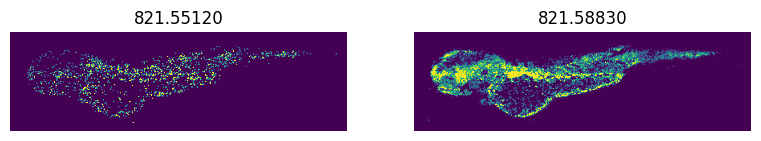

In [36]:
images = visualize_ranges_test(smz, PF)
fig = plt.figure(None, (20,10))
gs = plt.GridSpec(1,4)
for i, (mz, img) in enumerate(images.items()):
    plt.subplot(gs[i])
    plt.imshow(img, vmax=np.percentile(img, 98))
    plt.title(mz)
    plt.axis('off')
    
    